In [1]:
import os
import allel
import zarr
import pandas as pd
import petl as etl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
#import pyfasta
import sys
import random
import dask
import malariagen_data
ag3 = malariagen_data.Ag3("gs://vo_agam_release/")
nnz = np.count_nonzero

In [2]:
def log(*msg):
    print(' '.join(map(str, msg)), file=sys.stdout)
    sys.stdout.flush()

In [3]:
def subplots(*args, despine=None, **kwargs):
    fig, ax = plt.subplots(*args, **kwargs)
    if despine is None:
        despine = dict(offset=10, trim=False)
    if hasattr(ax, '__len__'):
        for a in ax:
            sns.despine(ax=a, **despine)
    else:
        sns.despine(ax=ax, **despine)
    return fig, ax

In [5]:
tbl_samples = etl.fromcsv('../Data/Meta/west_africa_phase3_n2.csv', delimiter=',')
ac_count = zarr.open('/media/randomx/Volume/Ag1000G/Phase3/Data/Extras/fw_biallelic_count_pca_pops.zarr/')

In [6]:
samples = list(tbl_samples['sample_id'])
samples = [str(s) for s in samples]
contigs = ['2R','2L', '3L','3R','X']

In [7]:
def select_populations(pop1, pop2, species_pop2):
    pop1 = tbl_samples.select(lambda r: r.population == pop1 and r.population == pop1).values('sample_id').list()
    pop2 = tbl_samples.select(lambda r: r.country == pop2 and r.species == species_pop2).values('sample_id').list()
    index_pop1 = [samples.index(i) for i in pop1]
    index_pop2 = [samples.index(i) for i in pop1]
    return index_pop1, index_pop2

In [8]:
def genotype_populations(pop1, pop2, chrom, species_pop2):
    ga = {chrom: ag3.snp_genotypes(chrom, site_mask="gamb_colu", sample_sets=["AG1000G-BF-A", "AG1000G-BF-B", "AG1000G-BF-C", "AG1000G-CI", "AG1000G-GH", "AG1000G-GM-A", "AG1000G-GM-B", 
                                       "AG1000G-GM-C", "AG1000G-GN-A", "AG1000G-GN-B", "AG1000G-ML-A", "AG1000G-ML-B", "AG1000G-GW"]) for chrom in contigs}
    pop1, pop2 = select_populations(pop1, pop2, species_pop2)
    g_pop1 = {chrom: allel.GenotypeDaskArray(ga[chrom]).take(pop1, axis=1) for chrom in contigs}
    random_index = random.sample(pop2, len(pop1))
    g_pop2 = {chrom: allel.GenotypeDaskArray(ga[chrom]).take(pop2, axis=1) for chrom in contigs}
    return g_pop1, g_pop2

In [9]:
def ac_count_populations (chrom, pop1, pop2):
    ac_pop1 = allel.AlleleCountsChunkedArray(ac_count[chrom][pop1])
    ac_col = allel.AlleleCountsChunkedArray(ac_count[chrom]['An.col'][:])
    ac_gam = allel.AlleleCountsChunkedArray(ac_count[chrom]['An.gam'][:])

    if (pop2 == "An.col"):
        ac_pop2 = ac_col
    else:
        if (pop2 == 'An.gam'):
            ac_pop2 = ac_gam
    return ac_pop1, ac_pop2

In [10]:
def compute_pair_fst(pop1, pop2, chrom, start, stop, size):
    
    # load allele counts for region
    pos, ref, alt = ag3.snp_sites(contig=chrom, site_mask= 'gamb_colu')
    pos = allel.SortedIndex(pos.compute())
    loc = pos.locate_range(start, stop)
    ac1, ac2 =  ac_count_populations(chrom, pop1, pop2)
    ac1 = ac1[loc]
    ac2 = ac2[loc] 
    
    # ascertain SNPs
    loc_asc = ac1.is_segregating() & ac2.is_segregating() & (ac1.max_allele() <= 1) & (ac2.max_allele() <= 1)
    log('ascertainment', pop1, pop2, chrom, start, stop, nnz(loc_asc))
    ac1 = ac1[loc_asc]
    ac2 = ac2[loc_asc]
    pos = pos[loc_asc]
    
    # compute Fst
    fst, se, vb, _ = allel.windowed_hudson_fst(pos,ac1, ac2, size)
    
    return (fst, se), vb, pos, loc_asc

In [11]:
def plot_genome_pair_fst(pop1, pop2, chrom, start, stop, size):
    (fst, se), vb, pos, _ = compute_pair_fst(pop1, pop2, chrom, start, stop, size=size)
    x = allel.moving_statistic(pos, np.median, size=size)
    fig, ax = subplots(figsize=(10, 3))
    ax.plot(x, vb, 'k-')
    ax.set_xlim(start, stop)
    ax.set_xlabel(chrom)
    ax.set_ylabel('$F_{ST}$')
    ax.set_title('%s vs %s' % (pop1, pop2))
    ax.grid(axis='y')
    ax.set_ylim(0, .5)

In [12]:
def plot_pair_fst(pop1, pop2, chrom, start, stop, size):
    # load allele counts for region
    pos = ag3.snp_sites(region=chrom, field='POS', site_mask= 'gamb_colu')
    pos = allel.SortedIndex(pos.compute())
    loc = pos.locate_range(start, stop)
    ac1, ac2 =  ac_count_populations(chrom, pop1, pop2)
    ac1 = ac1[loc]
    ac2 = ac2[loc] 
    
    # ascertain SNPs
    loc_asc = ac1.is_segregating() & ac2.is_segregating() & (ac1.max_allele() <= 1) & (ac2.max_allele() <= 1)
    log('ascertainment', pop1, pop2, chrom, start, stop, nnz(loc_asc))
    ac1 = ac1[loc_asc]
    ac2 = ac2[loc_asc]
    pos = pos[loc_asc]
    
    # compute Fst
    fst, windows, counts = allel.windowed_hudson_fst(pos,ac1, ac2, size, step=None)
    x = np.asarray(windows).mean(axis=1)
    #x = allel.moving_statistic(pos, np.median, size=size)
    return fst,x

## GA - CO Fst

In [12]:
a = plot_pair_fst('An.col', 'An.gam', '2R', start=1, stop=None, size=100_000)
b = plot_pair_fst('An.col', 'An.gam', '2L', start=1, stop=None, size=100_000)
c = plot_pair_fst('An.col', 'An.gam', '3R', start=1, stop=None, size=100_000)
d = plot_pair_fst('An.col', 'An.gam', '3L', start=1, stop=None, size=100_000)
e = plot_pair_fst('An.col', 'An.gam', 'X', start=1, stop=None, size=100_000)

ascertainment An.col An.gam 2R 1 None 2019508
ascertainment An.col An.gam 2L 1 None 2319050
ascertainment An.col An.gam 3R 1 None 2589917
ascertainment An.col An.gam 3L 1 None 1886088
ascertainment An.col An.gam X 1 None 845165


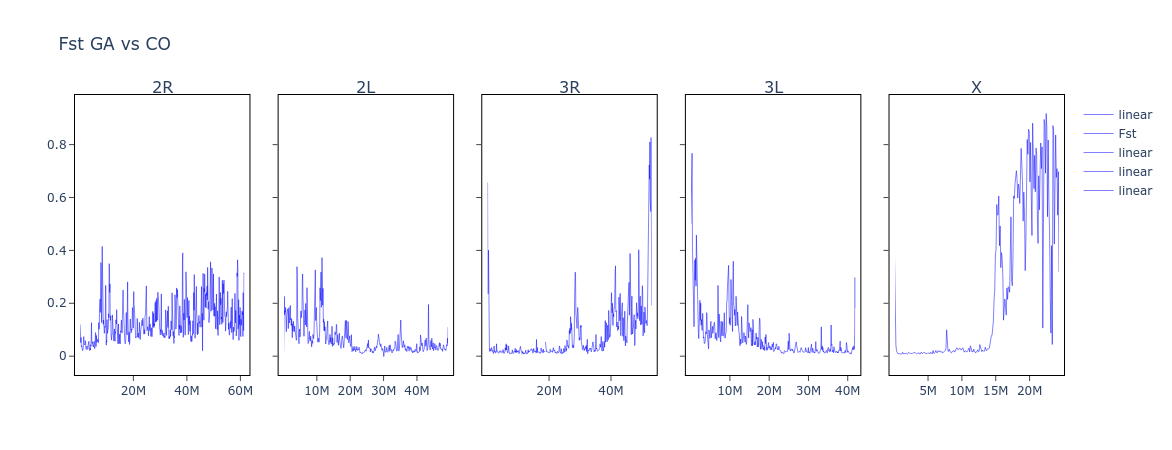

In [40]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=5, subplot_titles=("2R", "2L", "3R", "3L", "X"), shared_yaxes=True)

fig.add_trace(
    go.Scatter(x=a[1], y=a[0], name="linear",
                    line_shape='linear', line_color="#0000ff", line_width=0.5),
    row=1, col=1
)

fig.add_trace(go.Scatter(x=b[1], y=b[0], name="Fst",
                    line_shape='linear', line_color="#0000ff", line_width=0.5),
    row=1, col=2
)
fig.add_trace(go.Scatter(x=c[1], y=c[0], name="linear",
                    line_shape='linear', line_color="#0000ff", line_width=0.5),
    row=1, col=3
)
fig.update_xaxes(range=[-1e6, 6e7])

fig.add_trace(go.Scatter(x=d[1], y=d[0], name="linear",
                    line_shape='linear', line_color="#0000ff", line_width=0.5),
    row=1, col=4
)
fig.add_trace(go.Scatter(x=e[1], y=e[0], name="linear",
                    line_shape='linear', line_color="#0000ff", line_width=0.5),
    row=1, col=5
)
fig.update_layout(height=450, width=1200, title_text="Fst GA vs CO", yaxis_range=[0, 1], showlegend=True, plot_bgcolor = "white")
fig.update_xaxes(showline=True, linewidth=1, linecolor='black', ticks='outside', mirror=True)
fig.update_yaxes(showline=True, linewidth=1, linecolor='black', ticks='outside', mirror=True)
fig.update_layout(
    margin=dict(pad = 5),
)
fig.update_layout(
   xaxis = dict(
      tickmode = 'linear',
      tick0 = 0,
      dtick = 2e7,
   )
)
fig.show()

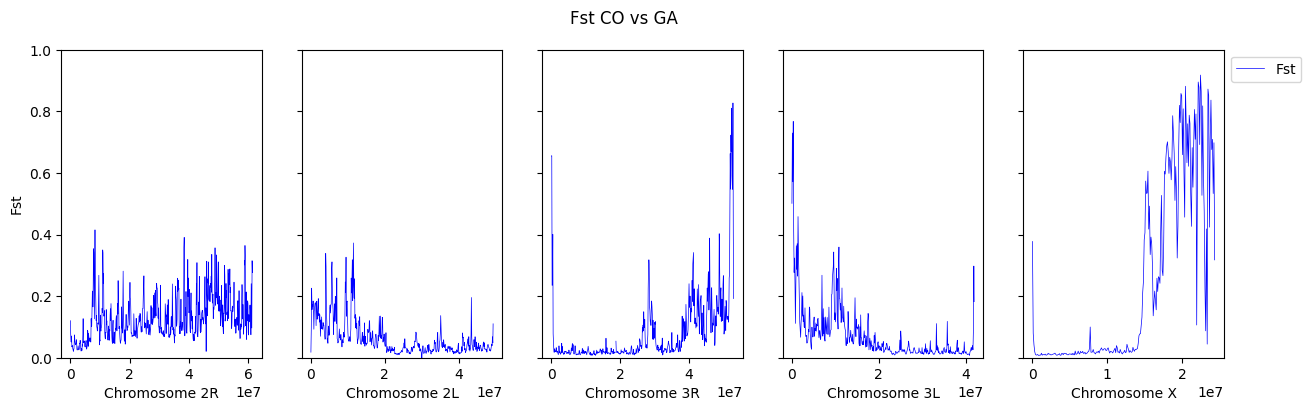

In [45]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15, 4))

fig.suptitle("Fst CO vs GA")
ax1.plot(a[1], a[0], lw=0.5, color="#0000ff")
ax1.set_ylabel("Fst")
ax1.set_xlabel('Chromosome 2R')
ax1.set_ylim(0, 1)


ax2.plot(b[1], b[0], lw=0.5, color="#0000ff")

ax2.set_xlabel('Chromosome 2L')
ax2.set_ylim(0, 1)

ax3.plot(c[1], c[0], lw=0.5, color="#0000ff")

ax3.set_xlabel('Chromosome 3R')
ax3.set_ylim(0, 1)

ax4.plot(d[1], d[0], lw=0.5, color="#0000ff")

ax4.set_xlabel('Chromosome 3L')
ax4.set_ylim(0, 1)

ax5.plot(e[1], e[0], lw=0.5, color="#0000ff", label= "Fst")
ax5.set_xlabel('Chromosome X')
ax5.set_ylim(0, 1)
ax5.legend(loc='upper left', bbox_to_anchor=(1, 1))
for ax in fig.get_axes():
    ax.label_outer()

## FW-GA Fst

In [46]:
a = plot_pair_fst('GM-1', 'An.gam', '2R', start=1, stop=None, size=100_000)
b = plot_pair_fst('GM-1', 'An.gam', '2L', start=1, stop=None, size=100_000)
c = plot_pair_fst('GM-1', 'An.gam', '3R', start=1, stop=None, size=100_000)
d = plot_pair_fst('GM-1', 'An.gam', '3L', start=1, stop=None, size=100_000)
e = plot_pair_fst('GM-1', 'An.gam', 'X', start=1, stop=None, size=100_000)

f = plot_pair_fst('GM-2', 'An.gam', '2R', start=1, stop=None, size=100_000)
g = plot_pair_fst('GM-2', 'An.gam', '2L', start=1, stop=None, size=100_000)
h = plot_pair_fst('GM-2', 'An.gam', '3R', start=1, stop=None, size=100_000)
i = plot_pair_fst('GM-2', 'An.gam', '3L', start=1, stop=None, size=100_000)
l = plot_pair_fst('GM-2', 'An.gam', 'X', start=1, stop=None, size=100_000)

m = plot_pair_fst('GW', 'An.gam', '2R', start=1, stop=None, size=100_000)
n = plot_pair_fst('GW', 'An.gam', '2L', start=1, stop=None, size=100_000)
o = plot_pair_fst('GW', 'An.gam', '3R', start=1, stop=None, size=100_000)
p = plot_pair_fst('GW', 'An.gam', '3L', start=1, stop=None, size=100_000)
q = plot_pair_fst('GW', 'An.gam', 'X', start=1, stop=None, size=100_000)

ascertainment GM-1 An.gam 2R 1 None 1672663
ascertainment GM-1 An.gam 2L 1 None 1898319
ascertainment GM-1 An.gam 3R 1 None 2280738
ascertainment GM-1 An.gam 3L 1 None 1654793
ascertainment GM-1 An.gam X 1 None 724279
ascertainment GM-2 An.gam 2R 1 None 1233693
ascertainment GM-2 An.gam 2L 1 None 1304557
ascertainment GM-2 An.gam 3R 1 None 1566740
ascertainment GM-2 An.gam 3L 1 None 1124689
ascertainment GM-2 An.gam X 1 None 436673
ascertainment GW An.gam 2R 1 None 1466391
ascertainment GW An.gam 2L 1 None 1610390
ascertainment GW An.gam 3R 1 None 1991186
ascertainment GW An.gam 3L 1 None 1446109
ascertainment GW An.gam X 1 None 631093


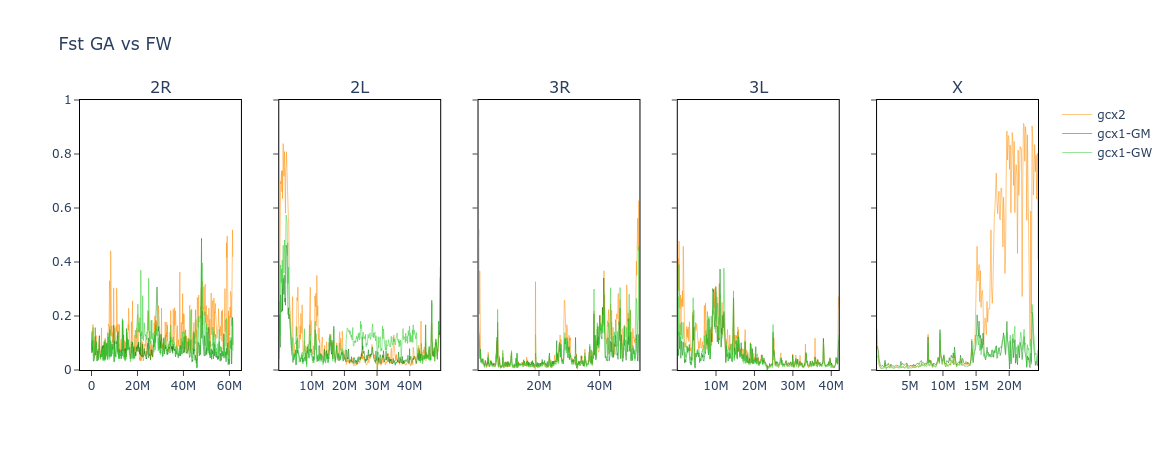

In [47]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=5, subplot_titles=("2R", "2L", "3R", "3L", "X"), shared_yaxes=True, shared_xaxes=False)

fig.add_trace(
    go.Scatter(x=a[1], y=a[0], name="gcx2",
                    line_shape='linear', line_color="darkorange", line_width=0.5, showlegend=True),
    row=1, col=1
)

fig.add_trace(go.Scatter(x=b[1], y=b[0], name="gcx2",
                    line_shape='linear', line_color="darkorange", line_width=0.5, showlegend=False),
    row=1, col=2
)
fig.add_trace(go.Scatter(x=c[1], y=c[0], name="gcx2",
                    line_shape='linear', line_color="darkorange", line_width=0.5, showlegend=False),
    row=1, col=3
)
fig.add_trace(go.Scatter(x=d[1], y=d[0], name="gcx2",
                    line_shape='linear', line_color="darkorange", line_width=0.5, showlegend=False),
    row=1, col=4
)
fig.add_trace(go.Scatter(x=e[1], y=e[0], name="gcx2",
                    line_shape='linear', line_color="darkorange", line_width=0.5, showlegend=False),
    row=1, col=5
)

fig.add_trace(
    go.Scatter(x=f[1], y=f[0], name="gcx1-GM",
                    line_shape='linear', line_color="green", line_width=0.5, showlegend=True),
    row=1, col=1
)

fig.add_trace(go.Scatter(x=g[1], y=g[0], name="gcx1-GM",
                    line_shape='linear', line_color="green", line_width=0.5, showlegend=False),
    row=1, col=2
)
fig.add_trace(go.Scatter(x=h[1], y=h[0], name="gcx1-GM",
                    line_shape='linear', line_color="green", line_width=0.5, showlegend=False),
    row=1, col=3
)
fig.add_trace(go.Scatter(x=i[1], y=i[0], name="gcx1-GM",
                    line_shape='linear', line_color="green", line_width=0.5, showlegend=False),
    row=1, col=4
)
fig.add_trace(go.Scatter(x=l[1], y=l[0], name="gcx1-GM",
                    line_shape='linear', line_color="green", line_width=0.5, showlegend=False),
    row=1, col=5
)

fig.add_trace(
    go.Scatter(x=m[1], y=m[0], name="gcx1-GW",
                    line_shape='linear', line_color="limegreen", line_width=0.5, showlegend=True),
    row=1, col=1
)

fig.add_trace(go.Scatter(x=n[1], y=n[0], name="gcx1-GW",
                    line_shape='linear', line_color="limegreen", line_width=0.5, showlegend=False),
    row=1, col=2
)
fig.add_trace(go.Scatter(x=o[1], y=o[0], name="gcx1-GW",
                    line_shape='linear', line_color="limegreen", line_width=0.5, showlegend=False),
    row=1, col=3
)
fig.add_trace(go.Scatter(x=p[1], y=p[0], name="gcx1-GW",
                    line_shape='linear', line_color="limegreen", line_width=0.5, showlegend=False),
    row=1, col=4
)
fig.add_trace(go.Scatter(x=q[1], y=q[0], name="gcx1-GW",
                    line_shape='linear', line_color="limegreen", line_width=0.5, showlegend=False),
    row=1, col=5
)
fig.update_layout(height=450, width=1200, title_text="Fst GA vs FW", yaxis_range=[0, 1], showlegend=True, xaxis_range=[-0.5e7, 6.5e7])

fig.update_layout(plot_bgcolor = "white")
fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
fig.update_xaxes(mirror=True, ticks='outside', showline=True)
fig.update_yaxes(mirror=True, ticks='outside', showline=True)
fig.show()

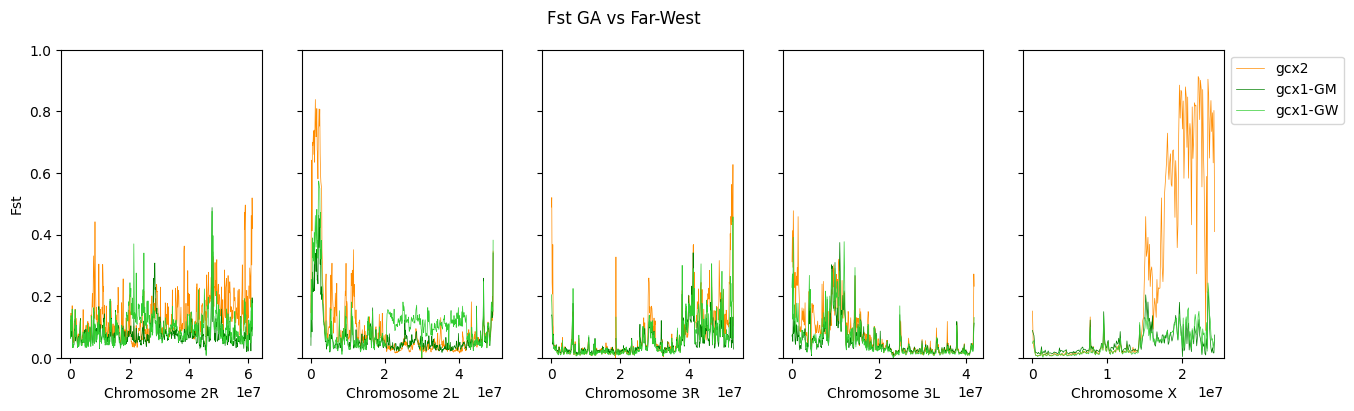

In [52]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15, 4))
fig.suptitle("Fst GA vs Far-West")
ax1.plot(a[1], a[0], lw=.5, color='darkorange')
ax1.plot(f[1], f[0], lw=.5, color='green')
ax1.plot(m[1], m[0], lw=.5, color='limegreen')

ax1.set_ylabel("Fst")
ax1.set_xlabel('Chromosome 2R')
ax1.set_ylim(0, 1)


ax2.plot(b[1], b[0], lw=.5, color='darkorange')
ax2.plot(g[1], g[0], lw=.5, color='green')
ax2.plot(n[1], n[0], lw=.5, color='limegreen')

ax2.set_xlabel('Chromosome 2L')
ax2.set_ylim(0, 1)

ax3.plot(c[1], c[0], lw=.5, color='darkorange')
ax3.plot(h[1], h[0], lw=.5, color='green')
ax3.plot(o[1], o[0], lw=.5, color='limegreen')

ax3.set_xlabel('Chromosome 3R')
ax3.set_ylim(0, 1)

ax4.plot(d[1], d[0], lw=.5, color='darkorange')
ax4.plot(i[1], i[0], lw=.5, color='green')
ax4.plot(p[1], p[0], lw=.5, color='limegreen')

ax4.set_xlabel('Chromosome 3L')
ax4.set_ylim(0, 1)

ax5.plot(e[1], e[0], lw=.5, color='darkorange', label= "gcx2")
ax5.plot(l[1], l[0], lw=.5, color='green', label= "gcx1-GM")
ax5.plot(q[1], q[0], lw=.5, color='limegreen', label= "gcx1-GW")

ax5.set_xlabel('Chromosome X')
ax5.set_ylim(0, 1)
ax5.legend(loc='upper left', bbox_to_anchor=(1, 1))
for ax in fig.get_axes():
    ax.label_outer()

--------------------------
## FW-CO Fst

In [53]:
a = plot_pair_fst('GM-1', 'An.col', '2R', start=1, stop=None, size=100_000)
b = plot_pair_fst('GM-1', 'An.col', '2L', start=1, stop=None, size=100_000)
c = plot_pair_fst('GM-1', 'An.col', '3R', start=1, stop=None, size=100_000)
d = plot_pair_fst('GM-1', 'An.col', '3L', start=1, stop=None, size=100_000)
e = plot_pair_fst('GM-1', 'An.col', 'X', start=1, stop=None, size=100_000)

f = plot_pair_fst('GM-2', 'An.col', '2R', start=1, stop=None, size=100_000)
g = plot_pair_fst('GM-2', 'An.col', '2L', start=1, stop=None, size=100_000)
h = plot_pair_fst('GM-2', 'An.col', '3R', start=1, stop=None, size=100_000)
i = plot_pair_fst('GM-2', 'An.col', '3L', start=1, stop=None, size=100_000)
l = plot_pair_fst('GM-2', 'An.col', 'X', start=1, stop=None, size=100_000)

m = plot_pair_fst('GW', 'An.col', '2R', start=1, stop=None, size=100_000)
n = plot_pair_fst('GW', 'An.col', '2L', start=1, stop=None, size=100_000)
o = plot_pair_fst('GW', 'An.col', '3R', start=1, stop=None, size=100_000)
p = plot_pair_fst('GW', 'An.col', '3L', start=1, stop=None, size=100_000)
q = plot_pair_fst('GW', 'An.col', 'X', start=1, stop=None, size=100_000)

ascertainment GM-1 An.col 2R 1 None 2060958
ascertainment GM-1 An.col 2L 1 None 2315416
ascertainment GM-1 An.col 3R 1 None 2598472
ascertainment GM-1 An.col 3L 1 None 1866811
ascertainment GM-1 An.col X 1 None 800732
ascertainment GM-2 An.col 2R 1 None 1035150
ascertainment GM-2 An.col 2L 1 None 1206815
ascertainment GM-2 An.col 3R 1 None 1488326
ascertainment GM-2 An.col 3L 1 None 1077391
ascertainment GM-2 An.col X 1 None 391329
ascertainment GW An.col 2R 1 None 1279648
ascertainment GW An.col 2L 1 None 1555148
ascertainment GW An.col 3R 1 None 1954081
ascertainment GW An.col 3L 1 None 1410230
ascertainment GW An.col X 1 None 590799


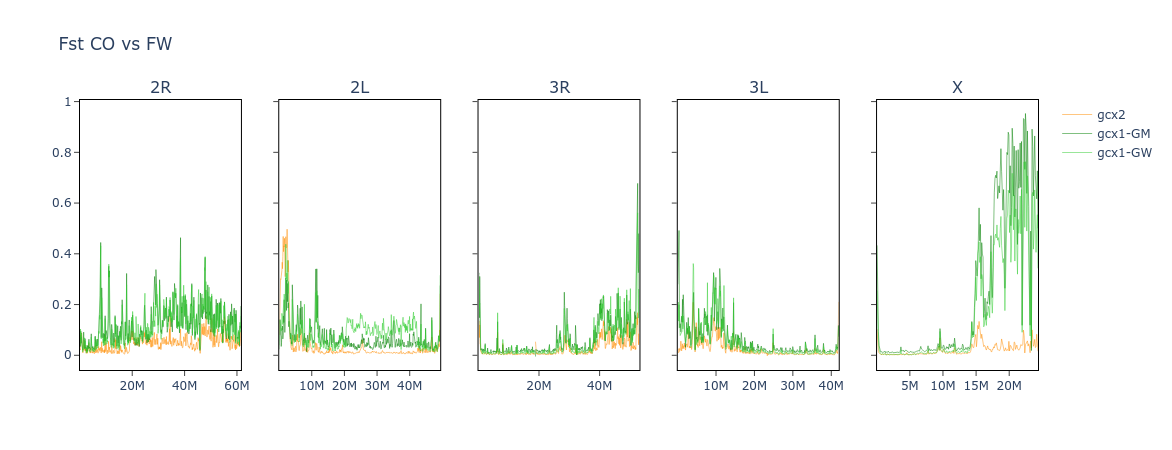

In [54]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=5, subplot_titles=("2R", "2L", "3R", "3L", "X"), shared_yaxes=True, shared_xaxes=False)

fig.add_trace(
    go.Scatter(x=a[1], y=a[0], name="gcx2",
                    line_shape='linear', line_color="darkorange", line_width=0.5, showlegend=True),
    row=1, col=1
)

fig.add_trace(go.Scatter(x=b[1], y=b[0], name="gcx2",
                    line_shape='linear', line_color="darkorange", line_width=0.5, showlegend=False),
    row=1, col=2
)
fig.add_trace(go.Scatter(x=c[1], y=c[0], name="gcx2",
                    line_shape='linear', line_color="darkorange", line_width=0.5, showlegend=False),
    row=1, col=3
)
fig.add_trace(go.Scatter(x=d[1], y=d[0], name="gcx2",
                    line_shape='linear', line_color="darkorange", line_width=0.5, showlegend=False),
    row=1, col=4
)
fig.add_trace(go.Scatter(x=e[1], y=e[0], name="gcx2",
                    line_shape='linear', line_color="darkorange", line_width=0.5, showlegend=False),
    row=1, col=5
)

fig.add_trace(
    go.Scatter(x=f[1], y=f[0], name="gcx1-GM",
                    line_shape='linear', line_color="green", line_width=0.5, showlegend=True),
    row=1, col=1
)

fig.add_trace(go.Scatter(x=g[1], y=g[0], name="gcx1-GM",
                    line_shape='linear', line_color="green", line_width=0.5, showlegend=False),
    row=1, col=2
)
fig.add_trace(go.Scatter(x=h[1], y=h[0], name="gcx1-GM",
                    line_shape='linear', line_color="green", line_width=0.5, showlegend=False),
    row=1, col=3
)
fig.add_trace(go.Scatter(x=i[1], y=i[0], name="gcx1-GM",
                    line_shape='linear', line_color="green", line_width=0.5, showlegend=False),
    row=1, col=4
)
fig.add_trace(go.Scatter(x=l[1], y=l[0], name="gcx1-GM",
                    line_shape='linear', line_color="green", line_width=0.5, showlegend=False),
    row=1, col=5
)

fig.add_trace(
    go.Scatter(x=m[1], y=m[0], name="gcx1-GW",
                    line_shape='linear', line_color="limegreen", line_width=0.5, showlegend=True),
    row=1, col=1
)

fig.add_trace(go.Scatter(x=n[1], y=n[0], name="gcx1-GW",
                    line_shape='linear', line_color="limegreen", line_width=0.5, showlegend=False),
    row=1, col=2
)
fig.add_trace(go.Scatter(x=o[1], y=o[0], name="gcx1-GW",
                    line_shape='linear', line_color="limegreen", line_width=0.5, showlegend=False),
    row=1, col=3
)
fig.add_trace(go.Scatter(x=p[1], y=p[0], name="gcx1-GW",
                    line_shape='linear', line_color="limegreen", line_width=0.5, showlegend=False),
    row=1, col=4
)
fig.add_trace(go.Scatter(x=q[1], y=q[0], name="gcx1-GW",
                    line_shape='linear', line_color="limegreen", line_width=0.5, showlegend=False),
    row=1, col=5
)
fig.update_layout(height=450, width=1200, title_text="Fst CO vs FW", yaxis_range=[0, 1], showlegend=True, xaxis_range=[-0.5e7, 6.5e7])

fig.update_layout(plot_bgcolor = "white")
fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
fig.update_xaxes(mirror=True, ticks='outside', showline=True)
fig.update_yaxes(mirror=True, ticks='outside', showline=True)
config = {'scrollZoom': True}
fig.show(config=config)

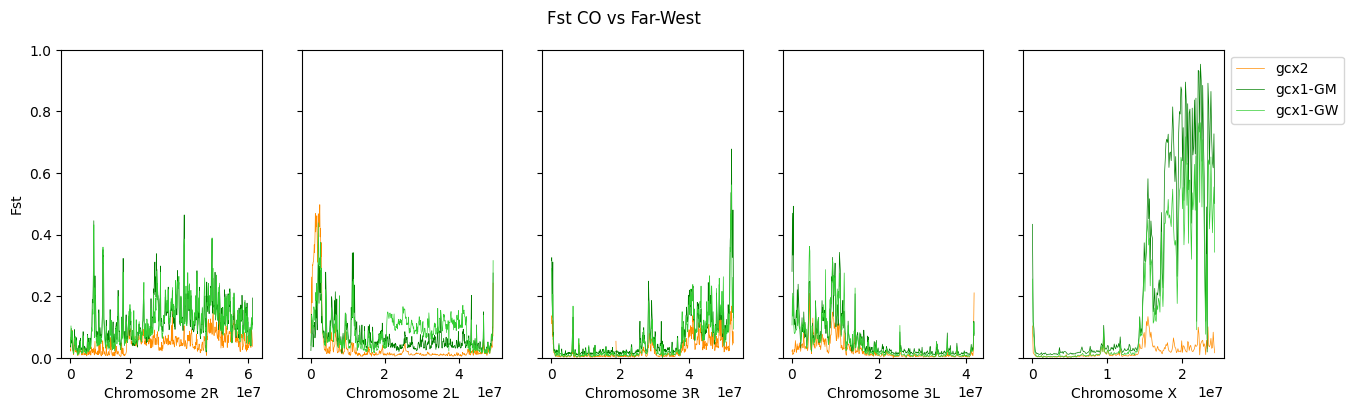

In [56]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15, 4))
fig.suptitle("Fst CO vs Far-West")
ax1.plot(a[1], a[0], lw=.5, color='darkorange')
ax1.plot(f[1], f[0], lw=.5, color='green')
ax1.plot(m[1], m[0], lw=.5, color='limegreen')

ax1.set_ylabel("Fst")
ax1.set_xlabel('Chromosome 2R')
ax1.set_ylim(0, 1)


ax2.plot(b[1], b[0], lw=.5, color='darkorange')
ax2.plot(g[1], g[0], lw=.5, color='green')
ax2.plot(n[1], n[0], lw=.5, color='limegreen')

ax2.set_xlabel('Chromosome 2L')
ax2.set_ylim(0, 1)

ax3.plot(c[1], c[0], lw=.5, color='darkorange')
ax3.plot(h[1], h[0], lw=.5, color='green')
ax3.plot(o[1], o[0], lw=.5, color='limegreen')

ax3.set_xlabel('Chromosome 3R')
ax3.set_ylim(0, 1)

ax4.plot(d[1], d[0], lw=.5, color='darkorange')
ax4.plot(i[1], i[0], lw=.5, color='green')
ax4.plot(p[1], p[0], lw=.5, color='limegreen')

ax4.set_xlabel('Chromosome 3L')
ax4.set_ylim(0, 1)

ax5.plot(e[1], e[0], lw=.5, color='darkorange', label= "gcx2")
ax5.plot(l[1], l[0], lw=.5, color='green', label= "gcx1-GM")
ax5.plot(q[1], q[0], lw=.5, color='limegreen', label= "gcx1-GW")

ax5.set_xlabel('Chromosome X')
ax5.set_ylim(0, 1)
ax5.legend(loc='upper left', bbox_to_anchor=(1, 1))
for ax in fig.get_axes():
    ax.label_outer()

--------------------------

### Top Fst

-------------------

In [13]:
populations = ['GM-1', 'GW', 'GM-2']

In [14]:
d = {}
for chrom in contigs:
    fst, pos = plot_pair_fst('GM-2', 'An.gam', chrom, start=1, stop=None, size=100_000)
    d[chrom] = pd.DataFrame()
    d[chrom]['Pos'] = pd.Series(pos[fst >= 0.2])
    d[chrom]['Fst'] = fst[fst>=0.2]
    d[chrom]['Population'] = 'gcx1-GM vs GA'
    d[chrom]['Chrom'] = chrom
df_gagcx1gm = pd.concat([v for k,v in d.items()])
df_gagcx1gm

ascertainment GM-2 An.gam 2R 1 None 1233693
ascertainment GM-2 An.gam 2L 1 None 1304557
ascertainment GM-2 An.gam 3L 1 None 1124689
ascertainment GM-2 An.gam 3R 1 None 1566740
ascertainment GM-2 An.gam X 1 None 436673


,Pos,Fst,Population,Chrom
0,28051089.5,0.257708,gcx1-GM vs GA,2R
1,28251089.5,0.214627,gcx1-GM vs GA,2R
2,28351089.5,0.260100,gcx1-GM vs GA,2R
3,28451089.5,0.304872,gcx1-GM vs GA,2R
4,28551089.5,0.307555,gcx1-GM vs GA,2R
...,...,...,...,...
4,41350371.5,0.340747,gcx1-GM vs GA,3R
5,41450371.5,0.245960,gcx1-GM vs GA,3R
6,46750371.5,0.229087,gcx1-GM vs GA,3R
0,15150246.5,0.204166,gcx1-GM vs GA,X


In [16]:
d = {}
for chrom in contigs:
    fst, pos = plot_pair_fst('GW', 'An.gam', chrom, start=1, stop=None, size=100_000)
    d[chrom] = pd.DataFrame()
    d[chrom]['Pos'] = pd.Series(pos[fst >= 0.2])
    d[chrom]['Fst'] = fst[fst>=0.2]
    d[chrom]['Population'] = 'gcx1-GW vs GA'
    d[chrom]['Chrom'] = chrom
df_gagcx1gw = pd.concat([v for k,v in d.items()])
df_gagcx1gw

ascertainment GW An.gam 2R 1 None 1466391
ascertainment GW An.gam 2L 1 None 1610390
ascertainment GW An.gam 3L 1 None 1446109
ascertainment GW An.gam 3R 1 None 1991186
ascertainment GW An.gam X 1 None 631093


,Pos,Fst,Population,Chrom
0,20051225.5,0.209481,gcx1-GW vs GA,2R
1,20151225.5,0.243549,gcx1-GW vs GA,2R
2,20251225.5,0.208043,gcx1-GW vs GA,2R
3,20451225.5,0.225498,gcx1-GW vs GA,2R
4,21451225.5,0.369678,gcx1-GW vs GA,2R
...,...,...,...,...
14,52350371.5,0.241567,gcx1-GW vs GA,3R
15,52850371.5,0.205518,gcx1-GW vs GA,3R
16,52950371.5,0.457403,gcx1-GW vs GA,3R
0,23450903.5,0.242783,gcx1-GW vs GA,X


In [17]:
d = {}
for chrom in contigs:
    fst, pos = plot_pair_fst('GM-1', 'An.gam', chrom, start=1, stop=None, size=100_000)
    d[chrom] = pd.DataFrame()
    d[chrom]['Pos'] = pd.Series(pos[fst >= 0.2])
    d[chrom]['Fst'] = fst[fst>=0.2]
    d[chrom]['Population'] = 'gcx2 vs GA'
    d[chrom]['Chrom'] = chrom
df_gagcx2 = pd.concat([v for k,v in d.items()])
df_gagcx2

ascertainment GM-1 An.gam 2R 1 None 1672663
ascertainment GM-1 An.gam 2L 1 None 1898319
ascertainment GM-1 An.gam 3L 1 None 1654793
ascertainment GM-1 An.gam 3R 1 None 2280738
ascertainment GM-1 An.gam X 1 None 724279


,Pos,Fst,Population,Chrom
0,7450262.5,0.205180,gcx2 vs GA,2R
1,7550262.5,0.208284,gcx2 vs GA,2R
2,7750262.5,0.232224,gcx2 vs GA,2R
3,7850262.5,0.330668,gcx2 vs GA,2R
4,7950262.5,0.295308,gcx2 vs GA,2R
...,...,...,...,...
83,23950232.5,0.734483,gcx2 vs GA,X
84,24050232.5,0.795475,gcx2 vs GA,X
85,24150232.5,0.632656,gcx2 vs GA,X
86,24250232.5,0.802723,gcx2 vs GA,X


In [18]:
d = {}
for chrom in contigs:
    fst, pos = plot_pair_fst('GM-2', 'An.col', chrom, start=1, stop=None, size=100_000)
    d[chrom] = pd.DataFrame()
    d[chrom]['Pos'] = pd.Series(pos[fst >= 0.2])
    d[chrom]['Fst'] = fst[fst>=0.2]
    d[chrom]['Population'] = 'gcx1-GM vs CO'
    d[chrom]['Chrom'] = chrom
df_cogcx1gm = pd.concat([v for k,v in d.items()])
df_cogcx1gm

ascertainment GM-2 An.col 2R 1 None 1035150
ascertainment GM-2 An.col 2L 1 None 1206815
ascertainment GM-2 An.col 3L 1 None 1077391
ascertainment GM-2 An.col 3R 1 None 1488326
ascertainment GM-2 An.col X 1 None 391329


,Pos,Fst,Population,Chrom
0,7751392.5,0.234421,gcx1-GM vs CO,2R
1,7851392.5,0.363571,gcx1-GM vs CO,2R
2,7951392.5,0.444753,gcx1-GM vs CO,2R
3,8051392.5,0.227022,gcx1-GM vs CO,2R
4,8351392.5,0.265756,gcx1-GM vs CO,2R
...,...,...,...,...
85,23950205.5,0.707819,gcx1-GM vs CO,X
86,24050205.5,0.635248,gcx1-GM vs CO,X
87,24150205.5,0.616540,gcx1-GM vs CO,X
88,24250205.5,0.726982,gcx1-GM vs CO,X


In [19]:
d = {}
for chrom in contigs:
    fst, pos = plot_pair_fst('GW', 'An.col', chrom, start=1, stop=None, size=100_000)
    d[chrom] = pd.DataFrame()
    d[chrom]['Pos'] = pd.Series(pos[fst >= 0.2])
    d[chrom]['Fst'] = fst[fst>=0.2]
    d[chrom]['Population'] = 'gcx1-GW vs CO'
    d[chrom]['Chrom'] = chrom
df_cogcx1gw = pd.concat([v for k,v in d.items()])
df_cogcx1gw

ascertainment GW An.col 2R 1 None 1279648
ascertainment GW An.col 2L 1 None 1555148
ascertainment GW An.col 3L 1 None 1410230
ascertainment GW An.col 3R 1 None 1954081
ascertainment GW An.col X 1 None 590799


,Pos,Fst,Population,Chrom
0,7851073.5,0.352202,gcx1-GW vs CO,2R
1,7951073.5,0.431659,gcx1-GW vs CO,2R
2,8051073.5,0.216579,gcx1-GW vs CO,2R
3,8351073.5,0.227050,gcx1-GW vs CO,2R
4,10951073.5,0.325606,gcx1-GW vs CO,2R
...,...,...,...,...
77,23950205.5,0.510230,gcx1-GW vs CO,X
78,24050205.5,0.405765,gcx1-GW vs CO,X
79,24150205.5,0.496132,gcx1-GW vs CO,X
80,24250205.5,0.554304,gcx1-GW vs CO,X


In [20]:
d = {}
for chrom in contigs:
    fst, pos = plot_pair_fst('GM-1', 'An.col', chrom, start=1, stop=None, size=100_000)
    d[chrom] = pd.DataFrame()
    d[chrom]['Pos'] = pd.Series(pos[fst >= 0.2])
    d[chrom]['Fst'] = fst[fst>=0.2]
    d[chrom]['Population'] = 'gcx2 vs CO'
    d[chrom]['Chrom'] = chrom
df_cogcx2 = pd.concat([v for k,v in d.items()])
df_cogcx2

ascertainment GM-1 An.col 2R 1 None 2060958
ascertainment GM-1 An.col 2L 1 None 2315416
ascertainment GM-1 An.col 3L 1 None 1866811
ascertainment GM-1 An.col 3R 1 None 2598472
ascertainment GM-1 An.col X 1 None 800732


,Pos,Fst,Population,Chrom
0,252227.5,0.261957,gcx2 vs CO,2L
1,452227.5,0.301636,gcx2 vs CO,2L
2,552227.5,0.299152,gcx2 vs CO,2L
3,652227.5,0.309790,gcx2 vs CO,2L
4,752227.5,0.312283,gcx2 vs CO,2L
5,852227.5,0.333576,gcx2 vs CO,2L
6,952227.5,0.366772,gcx2 vs CO,2L
7,1052227.5,0.341367,gcx2 vs CO,2L
8,1152227.5,0.390045,gcx2 vs CO,2L
9,1252227.5,0.468409,gcx2 vs CO,2L


In [21]:
frames = [df_gagcx1gm,df_gagcx1gw,df_gagcx2,df_cogcx1gm,df_cogcx1gw,df_cogcx2]
df_fst = pd.concat(frames)
df_fst

,Pos,Fst,Population,Chrom
0,28051089.5,0.257708,gcx1-GM vs GA,2R
1,28251089.5,0.214627,gcx1-GM vs GA,2R
2,28351089.5,0.260100,gcx1-GM vs GA,2R
3,28451089.5,0.304872,gcx1-GM vs GA,2R
4,28551089.5,0.307555,gcx1-GM vs GA,2R
...,...,...,...,...
25,2852227.5,0.373720,gcx2 vs CO,2L
26,2952227.5,0.287126,gcx2 vs CO,2L
27,49329119.5,0.242401,gcx2 vs CO,2L
0,4050588.5,0.209040,gcx2 vs CO,3L


In [22]:
df_fst.to_csv('../Data/Meta/230817_fst_all_chr.csv', sep="\t", index=None)

------------------------------------
## Get Fst genes

In [23]:
df_geneset = ag3.geneset().set_index("ID")
df_genes = df_geneset.query('type=="gene"').reset_index()
df_genes

,ID,contig,source,type,start,end,score,strand,phase,Parent,Name,description
0,AGAP004677,2L,VectorBase,gene,157348,186936,NaN,-,NaN,NaN,NaN,methylenetetrahydrofolate dehydrogenase(NAD ) ...
1,AGAP004678,2L,VectorBase,gene,203779,205293,NaN,+,NaN,NaN,NaN,NaN
2,AGAP004679,2L,VectorBase,gene,207894,210460,NaN,+,NaN,NaN,NaN,Folylpolyglutamate synthase [Source:UniProtKB/...
3,AGAP004680,2L,VectorBase,gene,271285,271815,NaN,+,NaN,NaN,NaN,NaN
4,AGAP004681,2L,VectorBase,gene,358329,359280,NaN,-,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
13052,AGAP001092,X,VectorBase,gene,24086190,24087589,NaN,+,NaN,NaN,NaN,NaN
13053,AGAP001093,X,VectorBase,gene,24094799,24142048,NaN,+,NaN,NaN,NaN,"fos-like antigen, invertebrate [Source:VB Comm..."
13054,AGAP001094,X,VectorBase,gene,24231498,24256349,NaN,-,NaN,NaN,run,runt [Source:VB Community Annotation]
13055,AGAP029221,Y_unplaced,VectorBase,gene,26264,27106,NaN,-,NaN,NaN,Yob,Male determiner protein Yob [Source:UniProtKB/...


In [24]:
def genes_scan(chrom, pos):
    df = df_genes[(df_genes.contig == chrom) & (df_genes.start >= pos-5000) & (df_genes.end < pos+5000) &
                   (df_genes.index.notna())]
    return df

In [25]:
fst_list = list(zip(list(df_fst.Chrom), list(df_fst.Pos)))

In [26]:
risultati = []
# Iterazione sulla lista di coppie di valori chrom e pos
for chrom, pos in fst_list:
    # Chiamata alla funzione genes_scan per ottenere il DataFrame
    df_risultato = genes_scan(chrom, pos)
    # Aggiunta del DataFrame ai risultati
    risultati.append(df_risultato)

# Concatenazione dei risultati in un unico DataFrame
df_completo = pd.concat(risultati)

In [28]:
##df_completo.groupby('ID').agg(df_completo.start.max(), df_completo.start.min())
df_grouped = df_completo.groupby('ID').agg({'contig':'first','start': 'min', 'end': 'max',  'description': 'first', 'strand':'first'}).reset_index()
df_grouped

,ID,contig,start,end,description,strand
0,AGAP000819,X,15252295,15254168,nuclear receptor subfamily 2 group E member (T...,+
1,AGAP000826,X,15348090,15353483,cap-specific mRNA (nucleoside-2'-O-)-methyltra...,+
2,AGAP000853,X,15745790,15750215,gamma-glutamyltranspeptidase [Source:VB Commun...,-
3,AGAP000888,X,16746634,16747763,glutathione S-transferase theta class 2 [Sourc...,-
4,AGAP000896,X,16949437,16950371,None,-
...,...,...,...,...,...,...
90,AGAP029481,3L,11747085,11750718,None,+
91,AGAP029671,X,15847495,15849211,None,+
92,AGAP029687,2L,2749618,2751783,None,-
93,AGAP029688,2L,2751786,2752176,None,-


In [31]:
import pandas as pd

# Primo DataFrame
df1 = df_grouped
# Secondo DataFrame
df2 = df_fst

# Unione dei due DataFrame basandoti sull'intervallo di posizioni
merged_df = pd.merge(df1, df2, left_on=['contig'], right_on=['Chrom'], how='inner')
merged_df = merged_df[merged_df['Pos'].between(merged_df['start'], merged_df['end'])]

# Stampa del DataFrame risultante
merged_df

,ID,contig,start,end,description,strand,Pos,Fst,Population,Chrom
272,AGAP000826,X,15348090,15353483,cap-specific mRNA (nucleoside-2'-O-)-methyltra...,+,15350232.5,0.347225,gcx2 vs GA,X
362,AGAP000826,X,15348090,15353483,cap-specific mRNA (nucleoside-2'-O-)-methyltra...,+,15350205.5,0.480514,gcx1-GM vs CO,X
452,AGAP000826,X,15348090,15353483,cap-specific mRNA (nucleoside-2'-O-)-methyltra...,+,15350205.5,0.416850,gcx1-GW vs CO,X
630,AGAP000853,X,15745790,15750215,gamma-glutamyltranspeptidase [Source:VB Commun...,-,15750205.5,0.301460,gcx1-GM vs CO,X
720,AGAP000853,X,15745790,15750215,gamma-glutamyltranspeptidase [Source:VB Commun...,-,15750205.5,0.233266,gcx1-GW vs CO,X
1074,AGAP000896,X,16949437,16950371,None,-,16950232.5,0.224893,gcx2 vs GA,X
1166,AGAP000896,X,16949437,16950371,None,-,16950205.5,0.252887,gcx1-GM vs CO,X
4824,AGAP001687,2R,8448761,8453272,None,-,8450262.5,0.274504,gcx2 vs GA,2R
5086,AGAP002639,2R,24850239,24851846,odorant receptor 39 [Source:VB Community Annot...,+,24851225.5,0.339998,gcx1-GW vs GA,2R
5115,AGAP002639,2R,24850239,24851846,odorant receptor 39 [Source:VB Community Annot...,+,24850262.5,0.216280,gcx2 vs GA,2R


In [32]:
merged_df.to_csv('../Data/Meta/230817_fst_genes.csv', sep=';')